In [1]:
import tensorflow 
print("Tensorflow Version: ", tensorflow.__version__)
print("Cuda Availability : ", tensorflow.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))


Tensorflow Version:  2.3.1
Cuda Availability :  True
Num GPUs Available:  0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import skimage.io
import tqdm
import os

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.utils import shuffle
Image.min(), Image.max()
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, ZeroPadding2D, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

In [3]:
os.getcwd()

'C:\\Users\\Intel'

In [4]:

cancerous      = os.listdir('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\yes')
non_cancerous  = os.listdir('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\no') 

In [5]:
len(cancerous), len(non_cancerous)

(155, 98)

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


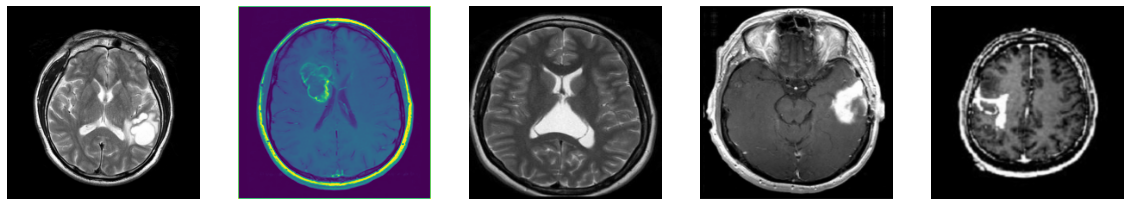

In [6]:

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(cancerous))
    img  = imread('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\yes\\' + cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


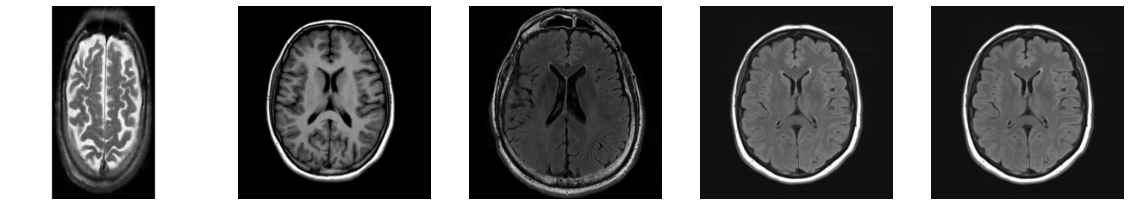

In [7]:

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(non_cancerous))
    img  = imread('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\no\\' + non_cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')
    

In [8]:

Image = []
Label = []

for i in tqdm(range(0, len(cancerous))):
    img = imread('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\yes\\' + cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(non_cancerous))):
    img = imread('C:\\Users\\Intel\\Documents\\brain_tumor_dataset\\no\\' + non_cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label) 

100%|██████████| 98/98 [00:06<00:00, 14.17it/s]


In [9]:

Image.min(), Image.max()

(0.0, 1.0)

In [10]:

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 27.10it/s]


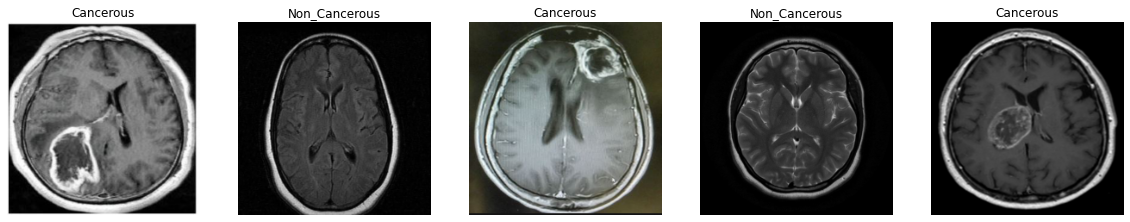

In [11]:

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Cancerous')
    else:
        ax[i].set_title('Non_Cancerous')

In [12]:

X = Image
y = Label

In [13]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [14]:

X_train.shape, X_val.shape

((177, 224, 224, 3), (76, 224, 224, 3))

In [15]:

train_datagen  = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range = 0.05,
                                    height_shift_range = 0.05,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    rotation_range = 30,
                                    fill_mode = 'nearest',
                                    zoom_range = 0.2,
                                    shear_range = 0.2) 

train_datagen.fit(X_train)

In [16]:
model = Sequential()

In [17]:
model.add(InputLayer(input_shape = (224,224,3)))
model.add(ZeroPadding2D((2,2), data_format = 'channels_last'))

model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Flatten())



model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))



model.add(Dense(units = 1, activation = 'sigmoid'))


In [18]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 113, 113, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 113, 113, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 64)        2

In [19]:
model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [20]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [21]:
model.fit(train_datagen.flow(X_train, y_train, batch_size = 32),
          validation_data = (X_val, y_val),
          epochs = 500,
          verbose = 1,
          callbacks = callback_list)

Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 0.9394 - accuracy: 0.6158
Epoch 00001: val_accuracy improved from -inf to 0.81579, saving model to .\best_weights.hdf5
6/6 [==============================] - 14s 2s/step - loss: 0.9394 - accuracy: 0.6158 - val_loss: 0.5537 - val_accuracy: 0.8158
Epoch 2/500
6/6 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.6723
Epoch 00002: val_accuracy did not improve from 0.81579
6/6 [==============================] - 6s 1s/step - loss: 0.7407 - accuracy: 0.6723 - val_loss: 0.5683 - val_accuracy: 0.6447
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7232
Epoch 00003: val_accuracy did not improve from 0.81579
6/6 [==============================] - 6s 1s/step - loss: 0.6128 - accuracy: 0.7232 - val_loss: 0.7490 - val_accuracy: 0.6184
Epoch 4/500
6/6 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7345
Epoch 00004: val_accuracy did not improve from

In [22]:
model.save("best_weights.hdf5")



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Cancerous Cell


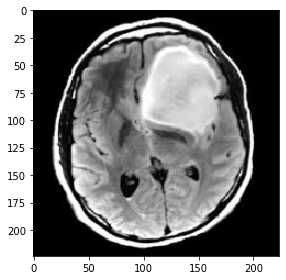

In [30]:

image = imread('C:\\Users\\Intel\Documents\\brain_tumor_dataset\\yes\Y105.jpg')
image = resize(image, (224,224,3))
imshow(image)
image = np.expand_dims(image, 0)

prediction  = model.predict_classes(image)

if prediction[0][0] == 1:
    print("Cancerous Cell")
else:
    print("Non-Cancerous Cell")
    
    